In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt

In [ ]:
# Load the dataset and make a random rotation
transform = transforms.Compose([
    transforms.RandomRotation(15, fill=255),  # Fill the border with white pixels
    transforms.ToTensor()])
dataset = datasets.ImageFolder("data/data/extracted_images", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Splitting into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloader for training and testing
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)



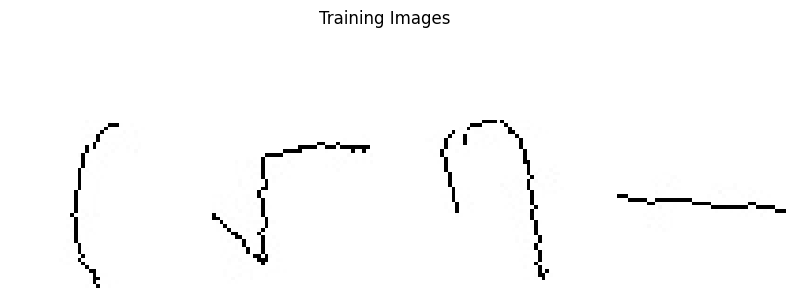

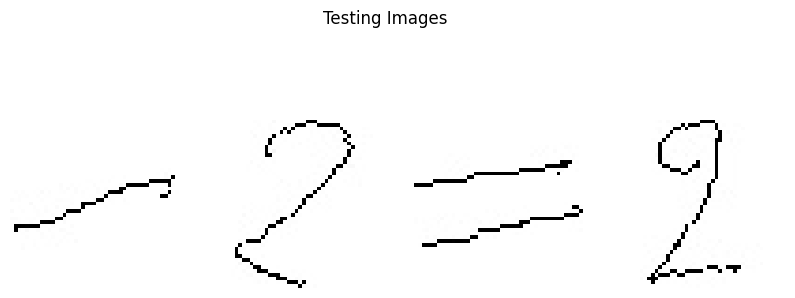

In [ ]:
# Testing data loader
train_images, train_labels = next(iter(train_dataloader))
test_images, test_labels = next(iter(test_dataloader))

# Plotting training images
fig1, axes1 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes1[i]
    ax.imshow(train_images[i].permute(1, 2, 0))
    ax.axis("off")
fig1.suptitle("Training Images")
plt.show()

# Plotting testing images
fig2, axes2 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes2[i]
    ax.imshow(test_images[i].permute(1, 2, 0))
    ax.axis("off")
fig2.suptitle("Testing Images")
plt.show()
